In [66]:
import nltk
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score)
import seaborn as sns

In [23]:
df = pd.read_csv("../DATA/deep_cleaned_corona_data.csv")
df = df.dropna(subset=['OriginalTweet', 'Sentiment']).reset_index(drop=True)

In [60]:
for i, j in df.iterrows():
    
    text = str(j["OriginalTweet"])
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    
    
    score_value = (score['pos'] - score['neg'])
    
    if score_value >= 0.15:
        df.loc[i, "VADER Sentiment"] = "Extremely Positive"
    elif score_value <= -0.15:
        df.loc[i, "VADER Sentiment"] = "Extremely Negative"
    elif score_value >= 0.05:
        df.loc[i, "VADER Sentiment"] = "Positive"
    elif score_value <= -0.05:
        df.loc[i, "VADER Sentiment"] = "Negative"
    else:
        df.loc[i, "VADER Sentiment"] = "Neutral"
        
    df.loc[i, 'neg'] = score['neg']
    df.loc[i, 'neu'] = score['neu']
    df.loc[i, 'pos'] = score['pos']
    df.loc[i, 'compound'] = score['compound']

In [61]:
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,VADER Sentiment,neg,neu,pos,compound,date
0,London,16-03-2020,and and,Neutral,Neutral,0.0,1.000,0.000,0.0000,2020-03-16
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,Positive,0.0,0.923,0.077,0.2500,2020-03-16
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Extremely Positive,0.0,0.800,0.200,0.4588,2020-03-16
3,"T: 36.319708,-82.363649",16-03-2020,As news of the regions first confirmed COVID-1...,Positive,Positive,0.0,0.912,0.088,0.4939,2020-03-16
4,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive,Positive,0.0,0.899,0.101,0.4215,2020-03-16


In [72]:
df.to_csv("../OUTPUTS/VADER_predictions.csv", index=False)

In [77]:
y_true = df['Sentiment']
y_pred = df['VADER Sentiment']
labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro  = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f'Accuracy:        {accuracy:.4f}')
print(f'Macro Precision: {precision:.4f}')
print(f'Macro Recall:    {recall:.4f}')
print(f'Macro F1:        {f1_macro:.4f}')

pd.DataFrame({
    'Model': ['VADER'], 'Accuracy': [accuracy],
    'Macro_Precision': [precision], 'Macro_Recall': [recall], 'Macro_F1': [f1_macro]
}).to_csv('../OUTPUTS/VADER_metrics.csv', index=False)

Accuracy:        0.6666
Macro Precision: 0.6868
Macro Recall:    0.6882
Macro F1:        0.6693


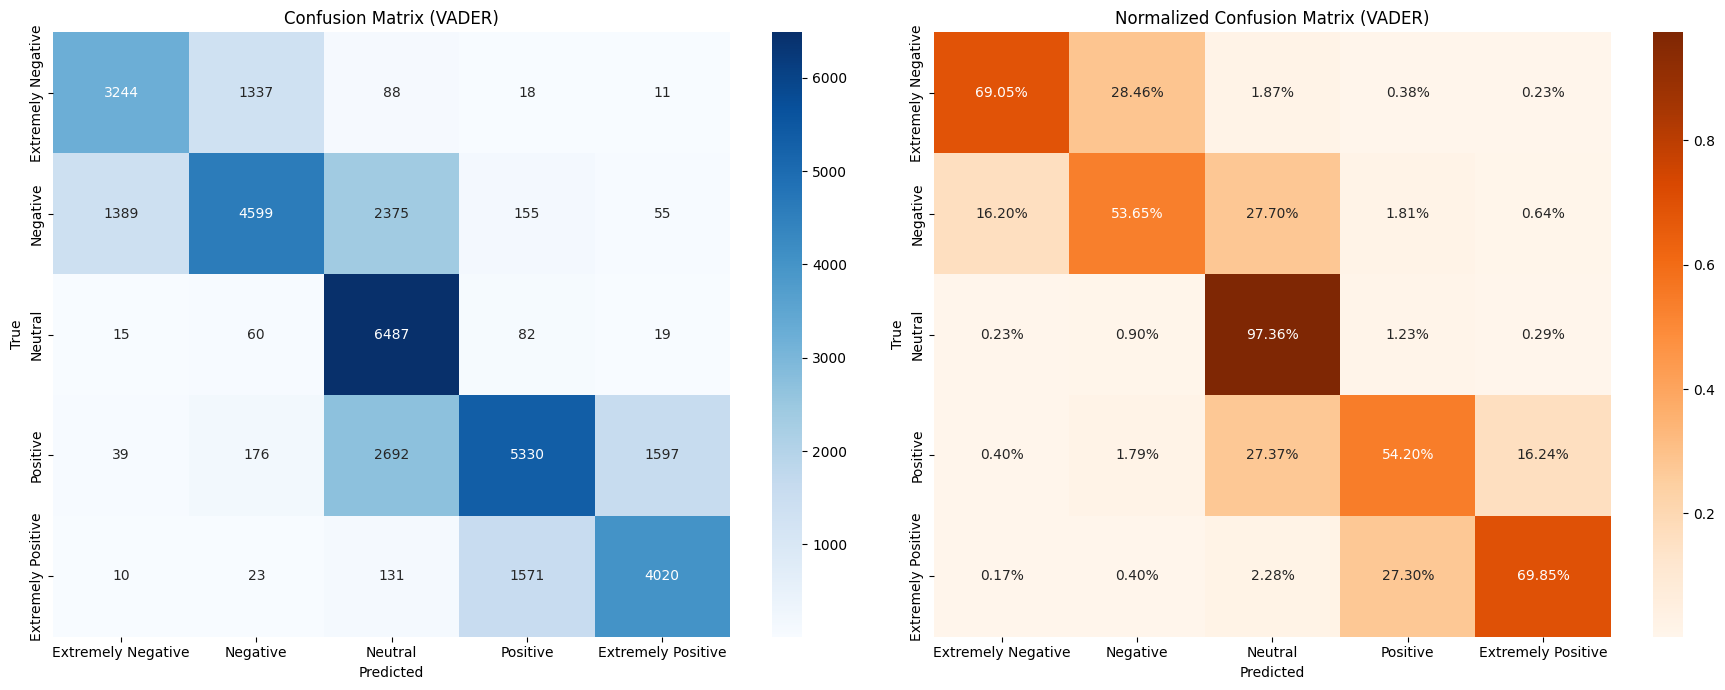

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels = labels)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix (VADER)')

cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Normalized Confusion Matrix (VADER)')

plt.tight_layout()
plt.savefig('../OUTPUTS/VADER_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

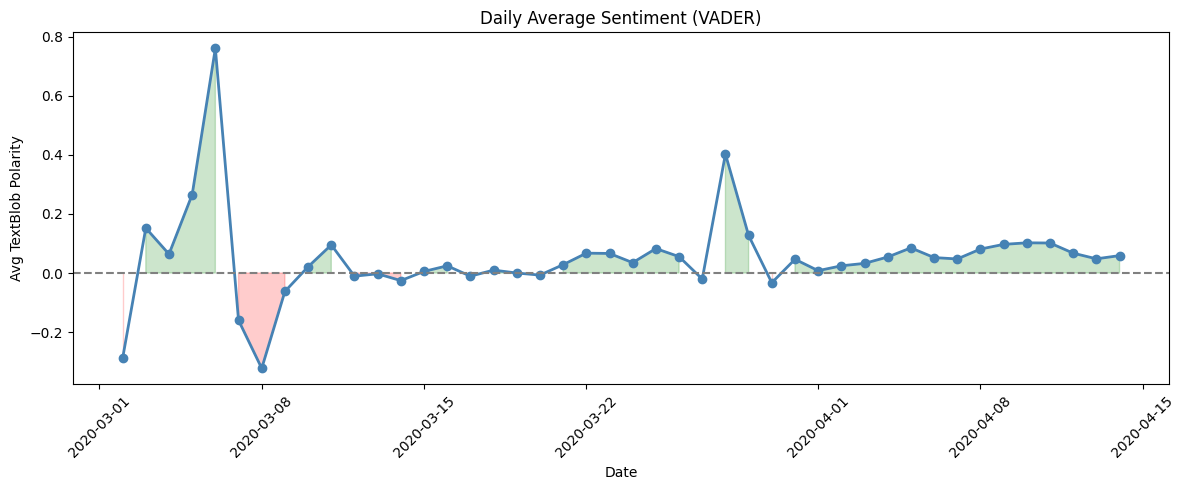

In [74]:
if 'TweetAt' in df.columns:
    df['date'] = pd.to_datetime(df['TweetAt'], dayfirst=True, errors='coerce')
    daily = df.groupby('date')['compound'].mean()

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(daily.index, daily.values, marker='o', linewidth=2, color='steelblue')
    ax.axhline(y=0, color='gray', linestyle='--')
    ax.fill_between(daily.index, daily.values, 0,
                    where=(daily.values >= 0), alpha=0.2, color='green')
    ax.fill_between(daily.index, daily.values, 0,
                    where=(daily.values < 0), alpha=0.2, color='red')
    ax.set_xlabel('Date')
    ax.set_ylabel('Avg TextBlob Polarity')
    ax.set_title('Daily Average Sentiment (VADER)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../OUTPUTS/VADER_sentiment_trend.png', dpi=150, bbox_inches='tight')
    plt.show()

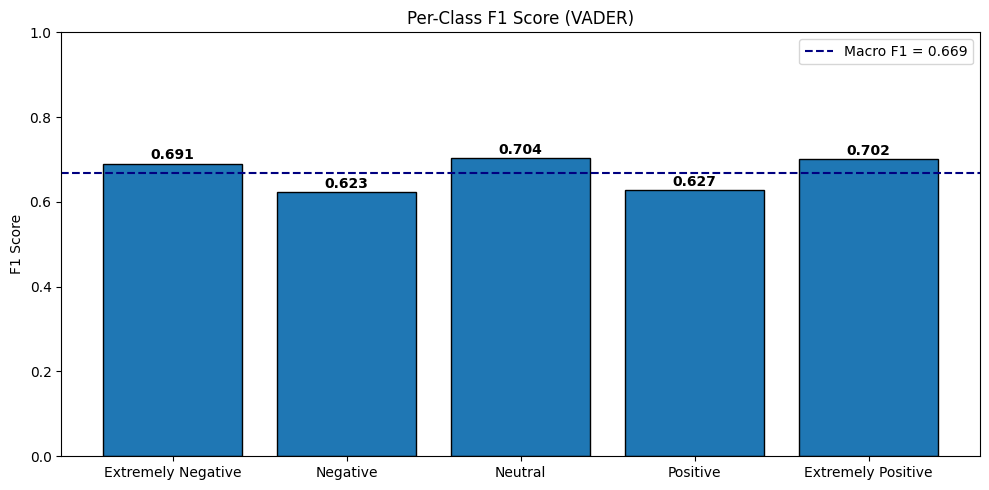

In [76]:
per_class_f1 = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(labels, per_class_f1, edgecolor='black')
for bar, val in zip(bars, per_class_f1):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', fontweight='bold')
ax.axhline(y=f1_macro, color='navy', linestyle='--', label=f'Macro F1 = {f1_macro:.3f}')
ax.set_ylim(0, 1.0)
ax.set_ylabel('F1 Score')
ax.set_title('Per-Class F1 Score (VADER)')
ax.legend()
plt.tight_layout()
plt.savefig('../OUTPUTS/VADER_per_class_f1.png', dpi=150, bbox_inches='tight')
plt.show()